# A/B Testing

Problem: The Product manager said that the current conversion rate is about 13% on average throughout the year and we want to see a 3% increase in the conversion rate. We are testing out this version of the product page to determine if we should roll-out this design.

Analysis: We will roll out this change to a small subset of users and test if the conversion rate increases to 16%. Our primary metric is the conversion rate.

In [4]:
import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [16]:
df = pd.read_csv("/Users/andreaseet/Downloads/ab_data.csv")

In [5]:
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
       'weight' : 'bold',
       'size'   : 14}

mpl.rc('font', **font)


# Designing the Experiment

Null hypothesis: The new landing page performs the same as the current landing page.

Alternative hypothesis: The new landing page performs better or worse than the current landing page.

We choose a two-tailed t-test because we do not know whether the landing page will perform better or worse.

# Choosing the sample size

Power set to 0.8: probability of finding a statistical difference between the groups in our test when a difference is actually present. We have about 80% chance to detect the conversion rate as statistically significant in our test with the sample size we calculated

p-value set to 0.05: probability under the assumption of no effect or no difference (null hypothesis), of obtaining a result equal to or more extreme than what was actually observed

Effect size: difference of 3%

In [32]:
effect_size = sms.proportion_effectsize(0.13, 0.16)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

2158


We need at least 2,158 observations in each group.

In [9]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [12]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [33]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


We will remove these users who appear multile times

In [34]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [35]:
#pulling 2,399 observations in each group
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [36]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
4311,710677,2017-01-11 01:36:19.989700,treatment,new_page,0
4312,869789,2017-01-14 23:54:21.396369,treatment,new_page,0
4313,898222,2017-01-16 18:10:59.604498,treatment,new_page,0
4314,908100,2017-01-23 14:59:25.155585,treatment,new_page,0


In [37]:
ab_test['group'].value_counts()

control      2158
treatment    2158
Name: group, dtype: int64

# Visualizing the Results

In [38]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.327,0.007
treatment,0.116,0.321,0.007


With the statistics above, our designs performed similarly (12.1% for the control and 11.6% for the treatment), with our new design performing slightly worse.

Text(0, 0.5, 'Converted (proportion)')

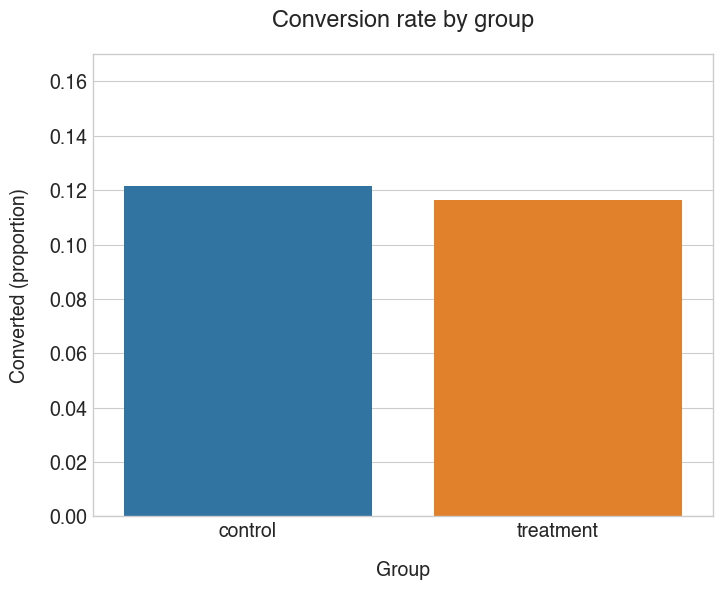

In [39]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

The conversion rate of 11.6% is less than our average yearly conversion rate of 13%. This goes to show that there is some variation in results when sampling from a population.

The treatment group's conversion rate is lower. Is the difference statistically significant?

# Testing the Hypothesis

In [40]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [41]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [42]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.52
p-value: 0.605
ci 95% for control group: [0.108, 0.135]
ci 95% for treatment group: [0.103, 0.130]


# Drawing Conclusions 

Since our p-value is 0.605 and is above the p-value of 0.05. We can not reject the null hypothesis, which means that our new design did not perform significantly different from our old one.

Additionally, if we look at the confidence itnerval for the treatment group, 10.3% to 13.0%, we notice that it includes our baseline value of 13.0% conversion rate and does not include our targeted value of 16.0%. This is proof that our new design does not perform better than the original design. We recommend not to move forward with the roll-out of this landing page.